Models to test:
- Lin reg. with all features
- Perform VIF, then Lin reg. with features where VIF < 5
- LASSO
- Ridge regression
- Elastic net
- SVM
- Random forest
- CART
- NN
- AdaBoost

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

random.seed(123456)
np.random.seed(123456)

# Read in data, drop first row since it doesn't have 1st order time series data
weather_df = pd.read_csv("weather-northern-clean.csv")
weather_df.drop(labels=0, axis=0, inplace=True)
weather_df.drop(columns=['Date', 'RainTomorrow'], inplace=True)
weather_df.dropna(inplace=True)
weather_df.loc[(weather_df['RainToday']=='Yes'),'RainToday'] = 1
weather_df.loc[(weather_df['RainToday']=='No'),'RainToday'] = 0

# Scale data, split into training and test sets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, roc_auc_score, accuracy_score,\
precision_score, recall_score, f1_score, mean_squared_error, make_scorer, explained_variance_score, r2_score

In [4]:
y = weather_df['RainfallTomorrow']
X_temp = weather_df.drop(columns=['RainfallTomorrow']).select_dtypes(include=[float, int])
X_scale = StandardScaler().fit(X_temp).transform(X_temp)
X = pd.DataFrame(X_scale, index=X_temp.index, columns=X_temp.columns)

categorical_df = weather_df.select_dtypes(exclude=[float,int])
for col in categorical_df.columns:
    temp_col = pd.get_dummies(categorical_df[col])
    X = pd.merge(left=X, right=temp_col, left_index=True, right_index=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123456, shuffle=True)

In [2]:
# Build a simple linear model as a baseline
from sklearn.linear_model import LinearRegression

LR_model = LinearRegression()

from sklearn.model_selection import cross_val_score
r2_adj = 1 - ((1-cross_val_score(LR_model, X_train, y_train, cv=5).mean())*(X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print(f'CV score for linear model using all features: {r2_adj:.4f}')

CV score for linear model using all features: 0.2295


In [3]:
def sklearn_vif(exogs, data):
    # initialize dictionaries
    vif_dict, tolerance_dict = {}, {}
    # form input data for each exogenous variable
    for exog in exogs:
        not_exog = [i for i in exogs if i != exog]
        X, y = data[not_exog], data[exog]
        # extract r-squared from the fit
        r_squared = LinearRegression().fit(X, y).score(X, y)
        # calculate VIF
        vif = 1/(1 - r_squared)
        vif_dict[exog] = vif
        # calculate tolerance
        tolerance = 1 - r_squared
        tolerance_dict[exog] = tolerance
    # return VIF DataFrame
    df_vif = pd.DataFrame({'VIF': vif_dict, 'Tolerance': tolerance_dict})
    return df_vif

vif_df = sklearn_vif(X_train.select_dtypes(include=['float']).columns, X_train)
vif_df

,VIF,Tolerance
Rainfall,2.108171,0.474345
Evaporation,2.599063,0.384754
WindGustSpeed,1.884081,0.530763
Humidity9am,3.613069,0.276773
Pressure9am,4.480954,0.223167
Cloud9am,2.396359,0.417300
AvgTemp,3.927525,0.254613
TempDiff,4.030618,0.248101
delta_Rainfall,1.712540,0.583928
delta_Evaporation,1.342036,0.745136


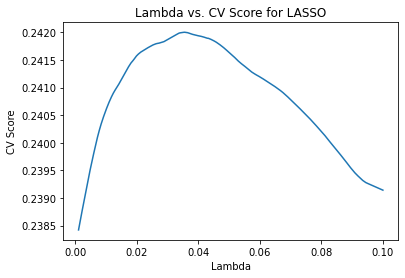


Max R^2 from LASSO: 0.24200273135560754


In [7]:
# Build a Lasso model
from sklearn.linear_model import Lasso

def RSS(y, y_pred):
    return np.sum(np.square(y - y_pred))

lasso_models = []
lasso_accuracy = []
alphas = np.linspace(0.001,0.1,500)
for i, alpha in enumerate(alphas):
    lasso_models.append(Lasso(alpha, max_iter=100000))
    lasso_accuracy.append(cross_val_score(lasso_models[i], X_train, y_train, cv=5).mean())

plt.plot(alphas, lasso_accuracy, '-')
plt.title('Lambda vs. CV Score for LASSO')
plt.xlabel('Lambda')
plt.ylabel('CV Score')
plt.show()

print(f'\nMax R^2 from LASSO: {max(lasso_accuracy)}')

# min_model = np.argmax(lasso_accuracy)
# print('Model coefficients:')
# for i, j in zip(lasso_models[min_model].fit(X, y).coef_, X_train.columns):
#     print(f'{j}: {i}')

In [12]:
best_lasso = lasso_models[np.argmax(lasso_accuracy)].fit(X_train, y_train)
lasso_vars = X_train.columns[best_lasso.coef_ != 0]
lasso_vars = X_train[lasso_vars]
lasso_vars

,Rainfall,Evaporation,WindGustSpeed,Humidity9am,Pressure9am,Cloud9am,AvgTemp,TempDiff,delta_Rainfall,delta_Evaporation,...,NNW_y,S_y,SE_y,SSW_y,WNW_y,E,SW,WSW,0,1
2372,-0.253874,-0.449469,-0.117899,-0.849037,2.071626,1.237571,-1.901077,-0.254759,-5.892748e-19,0.786721,...,0,0,0,0,0,0,0,0,1,0
7309,-0.253874,-0.874716,-0.517424,0.603330,-0.887212,-0.527415,0.823091,-0.254759,-1.841187e-01,-0.726338,...,0,0,0,0,0,0,0,0,1,0
6907,0.298470,-1.583460,-0.317661,0.911408,-1.598832,0.884574,0.613196,-0.473387,4.449536e-01,-1.210516,...,1,0,0,0,0,0,0,0,0,1
7021,-0.253874,-0.213221,-0.117899,-1.465192,0.255124,-1.233410,-0.418415,1.514142,-5.892748e-19,0.181497,...,0,0,1,0,0,0,0,0,1,0
514,-0.253874,-0.165971,-0.717186,0.163219,1.959265,-1.233410,-1.557207,0.421001,-5.892748e-19,0.181497,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3642,-0.140156,-0.969215,-0.117899,1.307508,-1.205568,1.237571,0.581935,-1.188897,-1.994620e-01,0.060453,...,0,0,0,0,1,0,0,0,0,1
3123,-0.253874,-0.118722,-0.117899,0.339263,0.067856,0.178579,0.479221,-0.851018,-5.892748e-19,-0.181637,...,0,0,0,0,0,0,0,0,1,0
4596,-0.253874,-0.874716,1.180554,0.867397,-0.625037,0.884574,0.689116,-1.010020,-2.424230e+00,-2.723575,...,0,1,0,0,0,0,0,0,1,0
6893,4.717218,-0.118722,-0.916948,0.867397,-0.812305,-0.174418,0.778433,0.063246,4.035269e+00,0.242020,...,0,0,0,0,0,0,0,0,0,1


In [13]:
adj_lasso_r2 = 1-(((1-max(lasso_accuracy))*(X_train.shape[0]-1))/(X_train.shape[0]-6-1))
print(f'Adjust Lasso R^2: {adj_lasso_r2}')

Adjust Lasso R^2: 0.2412735372539776


In [14]:
# Lin Model using Lasso variables
best_lasso = np.argmax(lasso_accuracy)
lasso_vars = X_train.columns[lasso_models[best_lasso].fit(X_train, y_train).coef_ != 0]

reduced_X_train = X_train[lasso_vars]

reduced_lin_model = LinearRegression()
print(f'CV score for linear model using Lasso features: {cross_val_score(reduced_lin_model, reduced_X_train, y_train).mean():.4f}')

CV score for linear model using Lasso features: 0.2437


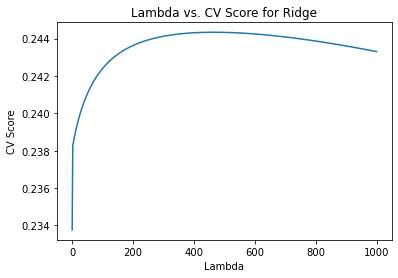


Max R^2 from Ridge: 0.24433929937964818


In [17]:
# Build ridge regression model
from sklearn.linear_model import Ridge

ridge_models = []
ridge_accuracy = []
alphas = np.linspace(0,1000,500)
for i, alpha in enumerate(alphas):
    ridge_models.append(Ridge(alpha, max_iter=100000))
    ridge_accuracy.append(cross_val_score(ridge_models[i], X_train, y_train, cv=5).mean())

plt.plot(alphas, ridge_accuracy, '-')
plt.title('Lambda vs. CV Score for Ridge')
plt.xlabel('Lambda')
plt.ylabel('CV Score')
plt.show()

print(f'\nMax R^2 from Ridge: {max(ridge_accuracy)}')

In [18]:
adj_ridge_r2 = 1-(((1-max(ridge_accuracy))*(X_train.shape[0]-1))/(X_train.shape[0]-X_train.shape[1]))
print(f'Adjust Ridge R^2: {adj_ridge_r2}')

Adjust Ridge R^2: 0.2358941117633857


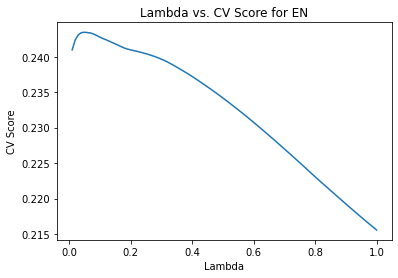


Max R^2 from Elastic Net: 0.24345954680292525


In [22]:
# Build elastic net model
from sklearn.linear_model import ElasticNet

EN_models = []
EN_accuracy = []
alphas = np.linspace(0.01,1,100)
for i, alpha in enumerate(alphas):
    EN_models.append(ElasticNet(alpha, max_iter=100000))
    EN_accuracy.append(cross_val_score(EN_models[i], X_train, y_train, cv=5).mean())

plt.plot(alphas, EN_accuracy, '-')
plt.title('Lambda vs. CV Score for EN')
plt.xlabel('Lambda')
plt.ylabel('CV Score')
plt.show()

print(f'\nMax R^2 from Elastic Net: {max(EN_accuracy)}')

In [23]:
best_EN = EN_models[np.argmax(EN_accuracy)]
np.sum(best_EN.fit(X_train, y_train).coef_ != 0)

41

In [24]:
adj_en_r2 = 1-(((1-max(EN_accuracy))*(X_train.shape[0]-1))/(X_train.shape[0]-13-1))
print(f'Adjust EN R^2: {adj_en_r2}')

Adjust EN R^2: 0.24188089096158305


In [25]:
# Build SVM Regression model
from sklearn.svm import SVR

init_svr_models = []
init_svr_accuracy = []
for i, kern in enumerate(['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']):
    if kern == 'poly':
        for deg in [2,3,4]:
            init_svr_models.append(SVR(kernel=kern, degree=deg, cache_size=1000))
    else:
        init_svr_models.append(SVR(kernel=kern, cache_size=1000))
    init_svr_accuracy.append(cross_val_score(init_svr_models[i], X_train, y_train, cv=5).mean())


In [26]:
min_model = np.argmax(init_svr_accuracy)
print(f'Best model before pX_train.shapearameter tuning: {init_svr_models[min_model].get_params()}')

Best model before pX_train.shapearameter tuning: {'C': 1.0, 'cache_size': 1000, 'coef0': 0.0, 'degree': 2, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In [27]:
#gammas = np.linspace(0.03, 0.1, 10)
# for gam in gammas:
#     svr_model = SVR(kernel='rbf', gamma=gam)
#     print(f'CV for gamma={gam} and RBF: {cross_val_score(svr_model, X_train, y_train).mean()}')

# for gam in gammas:
#     svr_model = SVR(kernel='poly', degree=2, gamma=gam)
#     print(f'CV for gamma={gam} and poly: {cross_val_score(svr_model, X_train, y_train).mean()}')

svr_model = SVR(kernel='poly', degree=2, gamma=0.09)
svr_r2 = cross_val_score(svr_model, X_train, y_train).mean()
print(f'Max R^2 from SVR: {svr_r2}')

Max R^2 from SVR: 0.20336502230776218


In [28]:
adj_svr_r2 = 1-(((1-svr_r2)*(X_train.shape[0]-1))/(X_train.shape[0]-X_train.shape[1]-1))
print(f'Adjust SVR R^2: {adj_svr_r2}')

Adjust SVR R^2: 0.19433141653448227


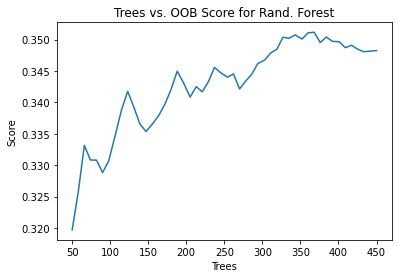

In [29]:
# Build a random forest model
from sklearn.ensemble import RandomForestRegressor

trees = np.linspace(50, 450, 50).astype(int)
RF_models = []
RF_accuracy = []

for i, tree in enumerate(trees):
    RF_models.append(RandomForestRegressor(n_estimators=tree, oob_score=True, n_jobs=-1, random_state=456789))
    RF_accuracy.append(RF_models[i].fit(X_train, y_train).oob_score_)
    
plt.plot(trees, RF_accuracy, '-')
plt.title('Trees vs. OOB Score for Rand. Forest')
plt.xlabel('Trees')
plt.ylabel('Score')
plt.show()

In [37]:
print(f'Max R^2 from Random Forest, using OOB: {np.max(RF_accuracy)}')
print(f'Best performing # of trees: {RF_models[np.argmax(RF_accuracy)].n_estimators}')
adj_rf_r2 = 1-(((1-np.max(RF_accuracy))*(X_train.shape[0]-1))/(X_train.shape[0]-X_train.shape[1]-1))
print(f'Adjust Rand Forest R^2: {adj_rf_r2}')

Max R^2 from Random Forest, using OOB: 0.3511556297070373
Best performing # of trees: 368
Adjust Rand Forest R^2: 0.34379792584821534


In [34]:
lasso_vars = X_train[lasso_vars]

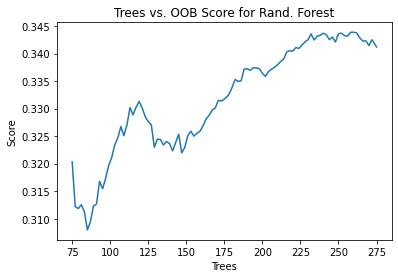

In [35]:
# Build a random forest model
from sklearn.ensemble import RandomForestRegressor

trees = np.linspace(75, 275, 100).astype(int)
lRF_models = []
lRF_accuracy = []

for i, tree in enumerate(trees):
    lRF_models.append(RandomForestRegressor(n_estimators=tree, oob_score=True, n_jobs=-1, random_state=456789))
    lRF_accuracy.append(lRF_models[i].fit(lasso_vars, y_train).oob_score_)
    
plt.plot(trees, lRF_accuracy, '-')
plt.title('Trees vs. OOB Score for Rand. Forest')
plt.xlabel('Trees')
plt.ylabel('Score')
plt.show()

In [36]:
# Lasso
print(f'Max R^2 from Random Forest, using OOB: {np.max(lRF_accuracy)}')
print(f'Best performing # of trees: {lRF_models[np.argmax(lRF_accuracy)].n_estimators}')
adj_lrf_r2 = 1-(((1-np.max(lRF_accuracy))*(lasso_vars.shape[0]-1))/(lasso_vars.shape[0]-lasso_vars.shape[1]-1))
print(f'Adjust Rand Forest R^2: {adj_lrf_r2}')

Max R^2 from Random Forest, using OOB: 0.3438734255042638
Best performing # of trees: 260
Adjust Rand Forest R^2: 0.34017425828336323


In [38]:
for q in [1,0.5,'log2','sqrt','auto']:
    temp_rf_model = RandomForestRegressor(n_estimators=368, oob_score=True, n_jobs=-1, max_features=q, random_state=456789).fit(X_train, y_train)
    print(f'For max_features={q}, OOB score={temp_rf_model.oob_score_}')
    

For max_features=1, OOB score=0.3069560363356797
For max_features=0.5, OOB score=0.3567073161801415
For max_features=log2, OOB score=0.35563585672195397
For max_features=sqrt, OOB score=0.36359074186124596
For max_features=auto, OOB score=0.3511556297070373


In [39]:
best_rf = RandomForestRegressor(n_estimators=368, oob_score=True, n_jobs=-1, max_features='sqrt', random_state=456789).fit(X_train, y_train)
adj_rf_r2 = 1-(((1-best_rf.oob_score_)*(X_train.shape[0]-1))/(X_train.shape[0]-X_train.shape[1]-1))
print(f'Adjust Rand Forest R^2: {adj_rf_r2}')

Adjust Rand Forest R^2: 0.3563740485079797


In [40]:
from IPython.display import Image

full_data = pd.merge(left=X, right=y, left_index=True, right_index=True)

sns_plot = sns.pairplot(full_data, height=2.0)
sns_plot.savefig("pairplot.png")

plt.clf() # Clean parirplot figure from sns 
Image(filename='pairplot.png') # Show pairplot as image

NameError: name 'sns' is not defined

In [41]:
# https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw
# Link above says that the large majority of NN's perform just as well with 1 layer as with multiple, and that
# the optimal number of nodes is almost always somewhere between the number of inputs (72) and the number of outputs (1)
# layers = np.linspace(26, 45, 20).astype(int)
# nn_models = []
# nn_accuracy = []
# for i, layer in enumerate(layers):
#     nn_models.append(MLPRegressor(hidden_layer_sizes=layer, max_iter=20000))
#     nn_accuracy.append(cross_val_score(nn_models[i], X_train, y_train))

nn_model = MLPRegressor(hidden_layer_sizes = 36, max_iter=20000)
print(f'Neural Net score: {cross_val_score(nn_model, X_train, y_train, cv=5).mean()}')

E:\Anaconda\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
E:\Anaconda\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
E:\Anaconda\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
E:\Anaconda\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
E:\Anaconda\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
ERROR:root:Internal Python error in the inspect module.
Below is the traceb

Neural Net score: -0.04859875449891371


KeyboardInterrupt



In [6]:
activations = ['relu', 'logistic', 'tanh']
solvers = ['adam', 'sgd', 'lbfgs']
layer_sizes = [3,5,8,10,25]

nn_models = []
nn_losses = []

for act in activations:
    for solve in solvers:
        for size in layer_sizes:
            nn_model = MLPRegressor(hidden_layer_sizes=size, activation=act, solver=solve, learning_rate='adaptive', max_iter=10000)
            nn_model.fit(X_train, y_train)
            nn_loss = nn_model.loss_
            nn_losses.append(nn_loss)
            nn_models.append(str(act) + '+' + str(solve) + '+' + str(size))
            print(str(act) + '+' + str(solve) + '+' + str(size) + 'done')

relu+adam+3done
relu+adam+5done
relu+adam+8done
relu+adam+10done
relu+adam+25done
relu+sgd+3done
relu+sgd+5done
relu+sgd+8done
relu+sgd+10done
relu+sgd+25done
relu+lbfgs+3done
relu+lbfgs+5done
relu+lbfgs+8done
relu+lbfgs+10done


E:\Anaconda\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


relu+lbfgs+25done
logistic+adam+3done
logistic+adam+5done
logistic+adam+8done


E:\Anaconda\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


logistic+adam+10done
logistic+adam+25done
logistic+sgd+3done
logistic+sgd+5done
logistic+sgd+8done
logistic+sgd+10done
logistic+sgd+25done
logistic+lbfgs+3done


E:\Anaconda\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


logistic+lbfgs+5done
logistic+lbfgs+8done
logistic+lbfgs+10done


E:\Anaconda\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


logistic+lbfgs+25done
tanh+adam+3done
tanh+adam+5done
tanh+adam+8done
tanh+adam+10done
tanh+adam+25done
tanh+sgd+3done
tanh+sgd+5done
tanh+sgd+8done
tanh+sgd+10done
tanh+sgd+25done
tanh+lbfgs+3done


E:\Anaconda\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


tanh+lbfgs+5done


E:\Anaconda\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


tanh+lbfgs+8done


E:\Anaconda\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


tanh+lbfgs+10done
tanh+lbfgs+25done


E:\Anaconda\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [8]:
nn_results = pd.DataFrame({'Model': nn_models, 'Loss': nn_losses})
nn_results

,Model,Loss
0,relu+adam+3,30.841324
1,relu+adam+5,36.488166
2,relu+adam+8,32.276632
3,relu+adam+10,22.406670
4,relu+adam+25,9.747979
5,relu+sgd+3,42.417066
6,relu+sgd+5,37.458806
7,relu+sgd+8,36.704163
8,relu+sgd+10,26.933932
9,relu+sgd+25,23.167569


In [10]:
np.argmin(nn_results['Loss'])

14

In [11]:
nn_model = MLPRegressor(hidden_layer_sizes=50, activation='relu', solver='lbfgs', learning_rate='adaptive', max_iter=10000)
nn_model.fit(X_train,y_train)
nn_model.loss_

E:\Anaconda\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


0.40673190331619774

In [24]:
nn_model = MLPRegressor(hidden_layer_sizes = 50, activation='relu', solver='lbfgs', learning_rate='adaptive', max_iter=20000)
nn_r2 = cross_val_score(nn_model, X_train, y_train, cv=5, scoring='r2').mean()
nn_adj_r2 = 1 - ((1-nn_r2)*(X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print(f'Neural Net score: {nn_adj_r2}')

E:\Anaconda\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
E:\Anaconda\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
E:\Anaconda\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. 

Neural Net score: -2.8416228522550657


In [25]:
nn_model = MLPRegressor(hidden_layer_sizes = 25, activation='relu', solver='lbfgs', learning_rate='adaptive', max_iter=10000)
nn_r2 = cross_val_score(nn_model, X_train, y_train, cv=5, scoring='r2').mean()
nn_adj_r2 = 1 - ((1-nn_r2)*(X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print(f'Neural Net score: {nn_adj_r2}')

E:\Anaconda\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
E:\Anaconda\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
E:\Anaconda\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

Neural Net score: -3.729503338373566


In [26]:
nn_model = MLPRegressor(hidden_layer_sizes = 25, activation='relu', solver='lbfgs', learning_rate='adaptive', max_iter=50000)
nn_r2 = cross_val_score(nn_model, X_train, y_train, cv=5, scoring='r2').mean()
nn_adj_r2 = 1 - ((1-nn_r2)*(X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print(f'Neural Net score: {nn_adj_r2}')

E:\Anaconda\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
E:\Anaconda\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
E:\Anaconda\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. 

Neural Net score: -4.50290415537259


E:\Anaconda\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [28]:
nn_model = MLPRegressor(hidden_layer_sizes = 10, activation='relu', solver='lbfgs', learning_rate='adaptive', max_iter=100000)
nn_r2 = cross_val_score(nn_model, X_train, y_train, cv=5, scoring='r2').mean()
nn_adj_r2 = 1 - ((1-nn_r2)*(X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print(f'Neural Net score: {nn_adj_r2}')

E:\Anaconda\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Neural Net score: -1.03058982354852


In [29]:
nn_model = MLPRegressor(hidden_layer_sizes = 8, activation='relu', solver='lbfgs', learning_rate='adaptive', max_iter=100000)
nn_r2 = cross_val_score(nn_model, X_train, y_train, cv=5, scoring='r2').mean()
nn_adj_r2 = 1 - ((1-nn_r2)*(X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print(f'Neural Net score: {nn_adj_r2}')

Neural Net score: -1.2122559588012325


In [30]:
nn_model = MLPRegressor(hidden_layer_sizes = 10, activation='relu', solver='sgd', learning_rate='adaptive', max_iter=100000)
nn_r2 = cross_val_score(nn_model, X_train, y_train, cv=5, scoring='r2').mean()
nn_adj_r2 = 1 - ((1-nn_r2)*(X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print(f'Neural Net score: {nn_adj_r2}')

Neural Net score: 0.17358635836335534


In [33]:
nn_model = MLPRegressor(hidden_layer_sizes = 25, activation='relu', solver='sgd', learning_rate='adaptive', max_iter=100000)
nn_r2 = cross_val_score(nn_model, X_train, y_train, cv=5, scoring='r2').mean()
nn_adj_r2 = 1 - ((1-nn_r2)*(X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print(f'Neural Net score: {nn_adj_r2}')

Neural Net score: 0.039789112453718634


In [35]:
sizes = []
scores = []

for size in range(24,0,-1):
    nn_model = MLPRegressor(hidden_layer_sizes = size, activation='relu', solver='sgd', learning_rate='adaptive', max_iter=100000)
    nn_r2 = cross_val_score(nn_model, X_train, y_train, cv=5, scoring='r2').mean()
    nn_adj_r2 = 1 - ((1-nn_r2)*(X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
    sizes.append(size)
    scores.append(nn_adj_r2)
    print(size, nn_adj_r2)

24 -0.02517431477670873
23 -0.04971600289051126
22 -0.026492955714756405
21 -0.11586298812620299
20 0.1237508106158961
19 -0.07697818907229936
18 -0.028698051081304854
17 -0.046091324757186136
16 0.17483414494588612
15 0.05914729803347529
14 0.04142655408810292
13 0.17711507469695142
12 0.07535831147494942
11 0.13133088236426915
10 0.08064527529536936
9 0.15710329899889441
8 0.15107428121821598
7 0.18877168180202186
6 0.222203821795543
5 0.18952341362822567
4 0.238894855562092
3 0.25192520066839663
2 0.18760390808836014
1 0.24780098735606815


Text(0, 0.5, 'Score')

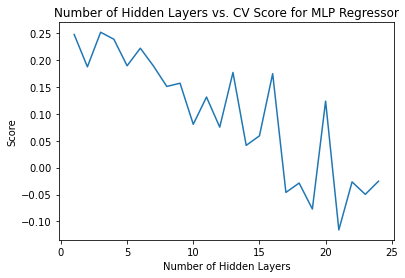

In [40]:
plt.plot(sizes[::-1], scores[::-1])
plt.title('Number of Hidden Layers vs. CV Score for MLP Regressor')
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Score')

In [34]:
nn_model = MLPRegressor(hidden_layer_sizes = 25, activation='logistic', solver='sgd', learning_rate='adaptive', max_iter=100000)
nn_r2 = cross_val_score(nn_model, X_train, y_train, cv=5, scoring='r2').mean()
nn_adj_r2 = 1 - ((1-nn_r2)*(X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print(f'Neural Net score: {nn_adj_r2}')

Neural Net score: -0.0908269520166991


In [32]:
nn_model = MLPRegressor(hidden_layer_sizes = 25, activation='relu', solver='adam', learning_rate='adaptive', max_iter=100000)
nn_r2 = cross_val_score(nn_model, X_train, y_train, cv=5, scoring='r2').mean()
nn_adj_r2 = 1 - ((1-nn_r2)*(X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print(f'Neural Net score: {nn_adj_r2}')

Neural Net score: -0.3757786829961587


In [31]:
nn_model = MLPRegressor(hidden_layer_sizes = 25, activation='tanh', solver='sgd', learning_rate='adaptive', max_iter=100000)
nn_r2 = cross_val_score(nn_model, X_train, y_train, cv=5, scoring='r2').mean()
nn_adj_r2 = 1 - ((1-nn_r2)*(X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print(f'Neural Net score: {nn_adj_r2}')

Neural Net score: -0.12821777207444662


In [ ]:
from sklearn.ensemble import AdaBoostRegressor

AB_model = AdaBoostRegressor()
print(f'AdaBoost Score: {cross_val_score(AB_model, X_train, y_train).mean()}')



## Best model score from above: Random Forest w/ adjusted r^2 of 0.373

In [ ]:
# def mean_absolute_percentage_error(y_true, y_pred):
#     denom = np.where(abs(y_true)<0.0000001,0.0000001, abs(y_true))
#     error_sum = (abs(y_true - y_pred)/denom).sum()
#     return error_sum/len(y_true)

# def root_mean_squared_error(y_true, y_pred):
#     return mean_squared_error(y_true, y_pred, squared=False)
    
MAE = make_scorer(mean_absolute_error)#, greater_is_better=False)
MAPE = make_scorer(mean_absolute_percentage_error)#, greater_is_better=False)
RMSE = make_scorer(root_mean_squared_error)#, greater_is_better=False)
MSE = make_scorer(mean_squared_error)#, greater_is_better=False)
exp_var = make_scorer(explained_variance_score)#, greater_is_better=False)
r_squared = make_scorer(r2_score)#, greater_is_better=False)
RF_r2 = cross_val_score(best_rf, X_test, y_test, scoring=r_squared).mean()

print(f'MAE using 5-fold CV: {cross_val_score(best_rf, X_test, y_test, scoring=MAE).mean()}')
# print(f'MAPE using 5-fold CV: {cross_val_score(best_rf, X_test, y_test, scoring=MAPE).mean()}')
# print(f'RMSE using 5-fold CV: {cross_val_score(best_rf, X_test, y_test, scoring=RMSE).mean()}')
print(f'MSE using 5-fold CV: {cross_val_score(best_rf, X_test, y_test, scoring=MSE).mean()}')
print(f'R^2 using 5-fold CV: {RF_r2}')
print(f'Explained Variance using 5-fold CV: {cross_val_score(best_rf, X_test, y_test, scoring=exp_var).mean()}')
# print(f'PM using 5-fold CV: {1-RF_r2}')